8. Using the carseats data set, we will predict sales using regression trees and related approaches, treating the response as a quantitative variable

In [1]:
import os
import pandas as pd

In [2]:
direct = os.getcwd()
carPath = os.path.join(direct, 'carseats.csv')
carseat = pd.read_csv(carPath)

In [3]:
def sl_quant(val):
    if val == 'Bad':
        return 0
    elif val == 'Medium':
        return 1
    else:
        return 2

In [4]:
carseat['ShelveLoc_quant'] = carseat['ShelveLoc'].apply(lambda x: sl_quant(x))
carseat['Urban_io'] = carseat['Urban'].apply(lambda x: 1 if x=='Yes' else 0)
carseat['US_io'] = carseat['US'].apply(lambda x: 1 if x=='Yes' else 0)
carseat = carseat.drop(columns=['ShelveLoc', 'Urban', 'US'])

a) split the data into a training and test set

In [5]:
y_data = carseat['Sales']
x_data = carseat.drop(columns = ['Sales'])

In [6]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(x_data, y_data, test_size=0.25, random_state=0)

b) Fit a regression tree to the training set.  Plot the tree, and interpret the results.  What test MSE do you obtain?

In [7]:
from sklearn.tree import DecisionTreeRegressor as dtReg

tree = dtReg(random_state=0)
model = tree.fit(x_train, y_train)

In [8]:
''' The following plots the tree, but it is uninterpretable

from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25,20))
_ = plot_tree(tree, 
                   feature_names=x_data.columns,  
                   class_names='Sales',
                   filled=True)
                   
'''

" The following plots the tree, but it is uninterpretable\n\nfrom sklearn.tree import plot_tree\nfrom matplotlib import pyplot as plt\n\nfig = plt.figure(figsize=(25,20))\n_ = plot_tree(tree, \n                   feature_names=x_data.columns,  \n                   class_names='Sales',\n                   filled=True)\n                   \n"

In [9]:
from sklearn.metrics import mean_squared_error as mse
mse(y_test, tree.predict(x_test))

5.191509000000001

c) Use cross validation to determine the optimal value of tree complexity.  Does pruning improve the test MSE?

In [10]:
data = []
for i in range(1, 15):
    tree = dtReg(random_state=0, max_depth=i)
    model = tree.fit(x_train, y_train)
    test_error = mse(y_test, tree.predict(x_test))
    data.append([i, test_error])

In [11]:
d = pd.DataFrame(data, columns=['Depth', 'MSE'])
d.plot(x='Depth', y='MSE');

In [12]:
data = []
for i in range(0, 50, 5):
    alpha = i/100.0
    tree = dtReg(random_state=0, max_depth=4, ccp_alpha = alpha)
    model = tree.fit(x_train, y_train)
    test_error = mse(y_test, tree.predict(x_test))
    data.append([alpha, test_error])

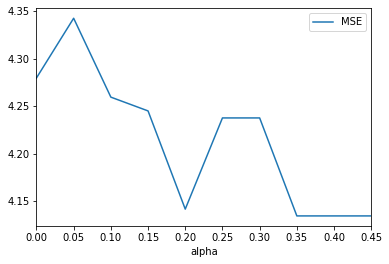

In [13]:
d = pd.DataFrame(data, columns=['alpha', 'MSE'])
d.plot(x='alpha', y='MSE');

****Answer:**** Yes, pruning improves the test MSE

d) Use the bagging approach in order to analyze this data.  What test MSE do you obtain?  Determine which variables are the most important.

In [14]:
from sklearn.ensemble import BaggingRegressor as bagReg
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score as cvScore

tree = dtReg(random_state=0, max_depth = 4)
trees = 100
bags = bagReg(base_estimator=tree, n_estimators = trees, random_state=0)
model = bags.fit(x_train, y_train)
mse(y_test, model.predict(x_test))

2.836586976453146

In [20]:
import numpy as np
feature_importances = np.mean([
    tree.feature_importances_ for tree in bags.estimators_
], axis=0)

features = pd.concat((pd.DataFrame(x_train.columns, columns=['variable']),
                     pd.DataFrame(feature_importances, columns=['importance'])),
                    axis=1).sort_values(by='importance', ascending=False)
print(features)

          variable  importance
7  ShelveLoc_quant    0.417512
4            Price    0.334558
5              Age    0.085665
0        CompPrice    0.054605
2      Advertising    0.050001
1           Income    0.025054
6        Education    0.015179
3       Population    0.013571
9            US_io    0.002728
8         Urban_io    0.001127


In [ ]:
features = pd.concat((pd.DataFrame(train[list(feats)].columns, columns = ['variable']), 
               pd.DataFrame(la_outliers.feature_importances_, columns = ['importance'])), 
              axis = 1).sort_values(by='importance', ascending = False)[:20]
print('\n', features, '\n')

e) Use random forests to do the same as d

In [22]:
from sklearn.ensemble import RandomForestRegressor as rfReg
rf = rfReg(random_state=0, max_depth=4, n_estimators=100)
model = rf.fit(x_train, y_train)
mse(y_test, model.predict(x_test))

2.8287435345120566

In [24]:
features = pd.concat((pd.DataFrame(x_train.columns, columns=['variable']),
                     pd.DataFrame(model.feature_importances_, columns=['importance'])),
                    axis=1).sort_values(by='importance', ascending=False)
print(features)

          variable  importance
7  ShelveLoc_quant    0.417521
4            Price    0.333724
5              Age    0.086000
0        CompPrice    0.054267
2      Advertising    0.049416
1           Income    0.025477
6        Education    0.015533
3       Population    0.013839
9            US_io    0.002642
8         Urban_io    0.001581


***
